# ***Importing libraries***

In [26]:
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set(style='darkgrid', font_scale=0.7)
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# ***Having a look at the dataset***

In [2]:
#inspecting the dataset 
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


As can be seen, the dataset contains 14 features associated with 8693 passanger instances. Some of the rows are contaminated with *Null* values; For now, I will leave the values in the dataset. Later, the performance of my model of choice will be assessed in two contexts: with *Null* values and without them.

# ***Data preprocessing***

Something to be noted right away is the insignificance of the ***'Name'*** column, as it bears no statistical meaning when considering its relationship with the ***'Transported'*** variable. Also, values in the ***'PassengerId'*** column contain a kind of a group identifier as their last digit, which will be extracted as valuable information. 
The values in the ***'Cabin'*** column can be partitioned into **deck/num/side** values. 
Each ID in the ***PassengerId*** column can be split into **group/number** values.

In [4]:
#dropping the 'Name' column
df.drop('Name', axis=1, inplace=True)
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False


In [5]:
#extracting valuable data from the aforementioned 'compound' data columns
df[["Deck","Num","Side"]] = df.pop("Cabin").str.split("/", expand=True)
df['Group'] = df['PassengerId'].str.slice(-1)
df['Number'] = df['PassengerId'].str.slice(0, 4)

#dropping 'PassengerId', as it is not necessary anymore
df.drop('PassengerId', axis=1, inplace=True)

Next, I would like to convert the qualitative columns of the dataset into quantitative ones, either by converting **True**, **False** values into **1**, **0** respectively or by one-hot encoding some of the features.

In [6]:
#converting qualitative columns into quantitative ones 
df['Transported'] = df['Transported'].astype(float)
df['CryoSleep'] = df['CryoSleep'].astype(float)

df = pd.get_dummies(df, columns=['HomePlanet', 'Destination'])

df['Number'] = df['Number'].astype(float)
df['Group'] = df['Group'].astype(float)
df['VIP'] = df['VIP'].astype(float)

In [7]:
cols = ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars','Destination_55 Cancri e', 'Destination_PSO J318.5-22','Destination_TRAPPIST-1e']

for i in cols:
    df[i] = df[i].astype(float)

# ***Data visualization with Seaborn, Matplotlib***

In [10]:
#choosing quantitative variables from the dataset
df_viz = df.drop(['Deck', 'Number', 'Side'], axis=1)

sns.pairplot(df_viz, kind='scatter', diag_kind="kde")
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ba51c690310> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ba51c6735b0> (for post_execute):


KeyboardInterrupt: 

Above is the visualization of the relationships between the various features of the dataset and the target variable, ***Transported*** created with scatterplots, KDE (essentially cdf) plots.

# ***Data analysis***

To gain more insights from the data and explore present correlations, I will create a correlation matrix of the features using the Spearman method to capture both linear and non-linear relationships in the data.

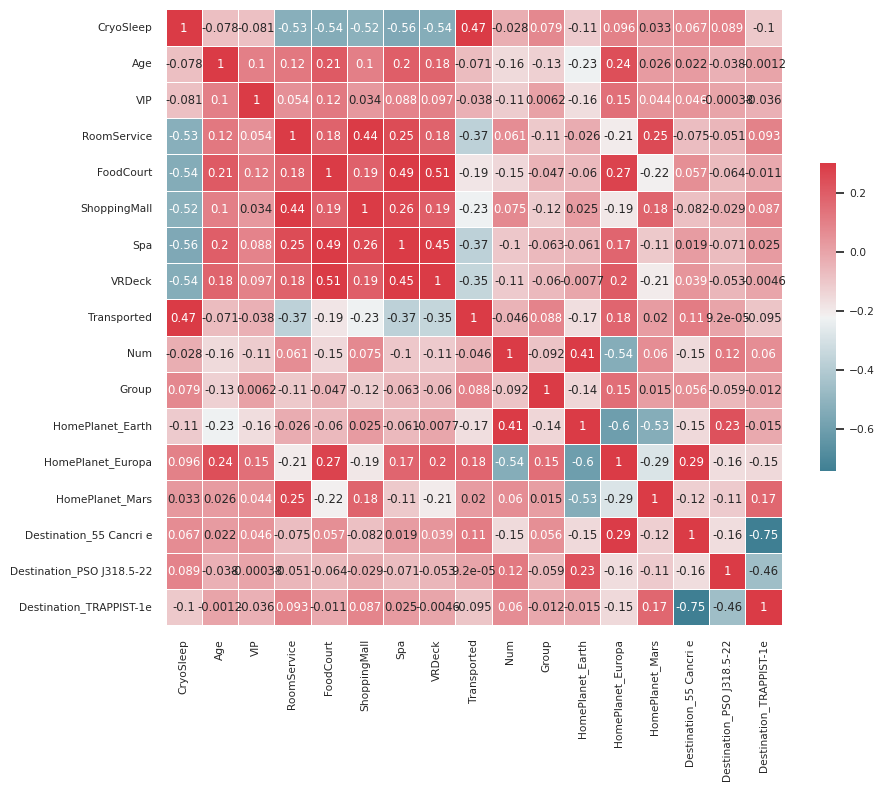

In [11]:
#creating a correlation matrix from the data
corr = df_viz.corr(method='spearman')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr, cmap=cmap, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [12]:
#printing the most significant (in terms of correlation) features
print('The features with the most correlation with the target variable:')
corr['Transported'].sort_values()[((corr['Transported'] >= 0.35) | (corr['Transported'] <= -0.35)) & (corr['Transported'] != 1)]

The features with the most correlation with the target variable:


Spa           -0.372582
RoomService   -0.371120
VRDeck        -0.352305
CryoSleep      0.468645
Name: Transported, dtype: float64

As can be seen, the variables with the most significance are ***Spa***, ***RoomService***, ***VRDeck***, ***CryoSLeep***. 
To theorize about the possible explanations of such relationships in the data, I will visualize the most significant correlations between the above 4 predictors and the other features from the dataset.

In [13]:
#printing the correlations between the aforementioned predictors and the other variables
features = ['Spa', 'RoomService', 'VRDeck', 'CryoSleep']
for f in features:
    print(f'The correlations between {f} and the other variables:')
    print(corr[f].sort_values()[((corr[f] >= 0.35) | (corr[f] <= -0.35)) & (corr[f] != 1)], '\n')

The correlations between Spa and the other variables:
CryoSleep     -0.557604
Transported   -0.372582
VRDeck         0.447894
FoodCourt      0.486395
Name: Spa, dtype: float64 

The correlations between RoomService and the other variables:
CryoSleep      -0.526264
Transported    -0.371120
ShoppingMall    0.443389
Name: RoomService, dtype: float64 

The correlations between VRDeck and the other variables:
CryoSleep     -0.536826
Transported   -0.352305
Spa            0.447894
FoodCourt      0.510977
Name: VRDeck, dtype: float64 

The correlations between CryoSleep and the other variables:
Spa            -0.557604
FoodCourt      -0.540177
VRDeck         -0.536826
RoomService    -0.526264
ShoppingMall   -0.520426
Transported     0.468645
Name: CryoSleep, dtype: float64 



The above correlations suggest the following:
* The passengers who paid for Spa were more likely to have also paid for VRDeck, FoodCourt. These passengers were also less likely to be transported, possibly because they had better cabin conditions;

* The people who paid for RoomService had less of a likelihood of also being confined to their cabin (CryoSleep). These people were also less likely to be transported;

* The CryoSleep parameter has a great positive correlation with the target variable. One cause of this could be that the more passengers moved around the spaceship, the more difficult of a target they became;

* Another logical conclusion is that the people who chose the CryoSleep option tended to pay for FoodCourt, VRDeck, RoomService (which is arguably rational), ShoppingMall less. They were also transported more often than the other passengers.

In [20]:
px.violin(df, x='Transported', y='Age')

People of ~20 years of age were more likely to be transported. Overall, younger people were a victim more frequently. 

In [21]:
px.violin(df, x='Transported', y='CryoSleep')

People who were not asleep were, as previous correlation analysis has also shown, transported less frequently. 

In [23]:
px.violin(df, x='Transported', y='HomePlanet_Earth') 
planets = ['Earth', 'Europa', 'Mars']

fig = make_subplots(rows=1, cols=3)


fig.add_trace(
    px.violin(),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

In [24]:
px.violin(df, x='Transported', y='HomePlanet_Europa')        

In [25]:
px.violin(df, x='Transported', y='HomePlanet_Mars')        

From the above **HomePlanet** vs **Transported** plots the following conclusions can be made:
* People from Earth, Europa were less likely to be transported;
* People from/not from Mars were equally likely to be transported. 